In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  Import libraries
import pandas as pd


#  Load the dataset
file_path = "/content/drive/My Drive/Conference paper/dataset/Sample_weather.csv"  # Update with correct file path if needed
df = pd.read_csv(file_path)


In [ ]:
#  Install necessary libraries (if needed)
!pip install pandas scikit-learn xgboost tensorflow --quiet

#  Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#  Drop the 'EventId' column (Fixes the previous TypeError)
df.drop(columns=["EventId"], inplace=True)

#  Convert timestamps to event duration
df["StartTime(UTC)"] = pd.to_datetime(df["StartTime(UTC)"], errors='coerce')
df["EndTime(UTC)"] = pd.to_datetime(df["EndTime(UTC)"], errors='coerce')
df["Event_Duration"] = (df["EndTime(UTC)"] - df["StartTime(UTC)"]).dt.total_seconds() / 3600  # Convert to hours

#  Drop original timestamp columns
df.drop(columns=["StartTime(UTC)", "EndTime(UTC)"], inplace=True)

# Drop `City` and `County` to fix numeric conversion issue
df.drop(columns=["City", "County"], inplace=True)  # Optional: Encode instead of dropping

# Encode categorical columns
categorical_cols = ["Type", "Severity", "TimeZone", "AirportCode", "State"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Store encoders if needed later

# Handle missing values
df.fillna(df.median(), inplace=True)

# Define features (X) and target (y)
X = df.drop(columns=["Type"])  # Using 'Type' as the prediction target
y = df["Type"]

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train & Evaluate Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_accuracy = rf_model.score(X_test_scaled, y_test)

# Train & Evaluate XGBoost Model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_accuracy = xgb_model.score(X_test_scaled, y_test)

# Train & Evaluate LSTM Model
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(25, activation='relu'),
    Dense(len(y.unique()), activation='softmax')  # Multi-class classification
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

# Compute Model Accuracy
lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test)[1]

# Display Model Performance
print("\n📊 Model Performance:")
print(f"✅ Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"✅ XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"✅ LSTM Accuracy: {lstm_accuracy:.4f}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - accuracy: 0.7685 - loss: 0.5925
Epoch 2/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - accuracy: 0.8431 - loss: 0.3724
Epoch 3/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - accuracy: 0.8540 - loss: 0.3418
Epoch 4/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.8568 - loss: 0.3313
Epoch 5/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.8593 - loss: 0.3229
Epoch 6/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.8604 - loss: 0.3194
Epoch 7/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.8605 - loss: 0.3158
Epoch 8/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - accuracy: 0.8619 - loss: 0.3136
Epoch 9/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.8617 - loss: 0.3119
Epoch 10/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - accuracy: 0.8625 - loss: 0.3112
Epoch 11/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - accuracy: 0.8632 - loss: 0.3086
Epoch 12

In [ ]:
# 📌 Import regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 📌 Generate predictions for each model
rf_preds = rf_model.predict(X_test_scaled)
xgb_preds = xgb_model.predict(X_test_scaled)
lstm_preds = lstm_model.predict(X_test_lstm)
lstm_preds = lstm_preds.argmax(axis=1)  # Convert probabilities to class labels

# 📌 Compute MAE, RMSE, and R² for each model
results = {
    "Model": ["Random Forest", "XGBoost", "LSTM"],
    "Accuracy": [rf_accuracy, xgb_accuracy, lstm_accuracy],
    "MAE": [
        mean_absolute_error(y_test, rf_preds),
        mean_absolute_error(y_test, xgb_preds),
        mean_absolute_error(y_test, lstm_preds)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, rf_preds)),  # Manually computing RMSE
        np.sqrt(mean_squared_error(y_test, xgb_preds)),  # Manually computing RMSE
        np.sqrt(mean_squared_error(y_test, lstm_preds))  # Manually computing RMSE
    ],
    "R2 Score": [
        r2_score(y_test, rf_preds),
        r2_score(y_test, xgb_preds),
        r2_score(y_test, lstm_preds)
    ]
}

# 📌 Convert results to DataFrame
df_results = pd.DataFrame(results)

# 📌 Display final performance metrics
print("\n📊 Final Model Performance:")
print(df_results)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

📊 Final Model Performance:
           Model  Accuracy      MAE      RMSE  R2 Score
0  Random Forest   0.86606  0.16465  0.570745  0.852511
1        XGBoost   0.86994  0.15587  0.535882  0.869979
2           LSTM   0.86617  0.16000  0.539833  0.868055


<ipython-input-6-2fba284a303a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importance[:10], y=xgb_importance.index[:10], palette="viridis")
<ipython-input-6-2fba284a303a>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importance[:10], y=rf_importance.index[:10], palette="magma")


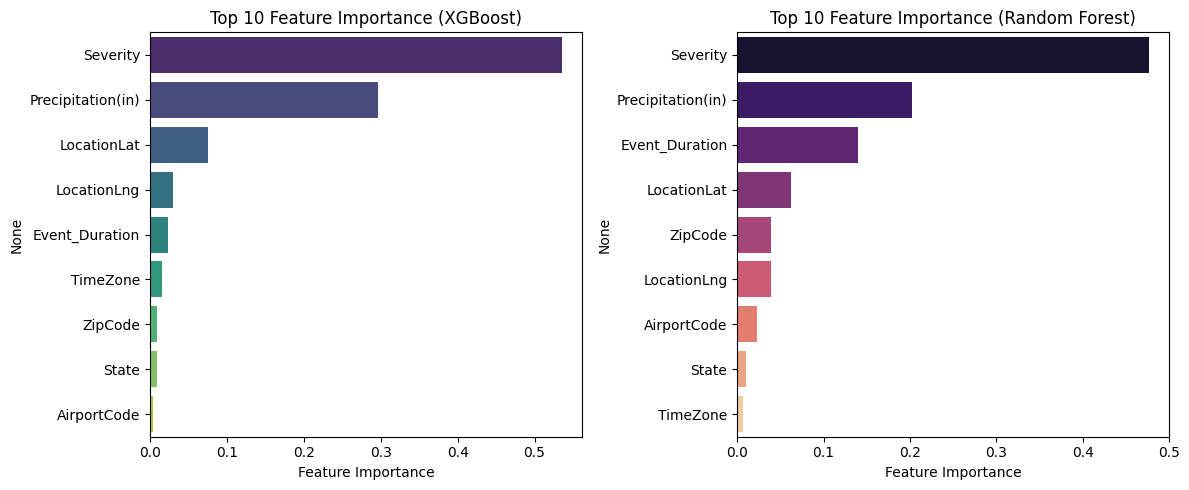

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Get feature importance for XGBoost
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# 📌 Get feature importance for Random Forest
rf_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# 📌 Plot feature importance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=xgb_importance[:10], y=xgb_importance.index[:10], palette="viridis")
plt.title("Top 10 Feature Importance (XGBoost)")
plt.xlabel("Feature Importance")

plt.subplot(1, 2, 2)
sns.barplot(x=rf_importance[:10], y=rf_importance.index[:10], palette="magma")
plt.title("Top 10 Feature Importance (Random Forest)")
plt.xlabel("Feature Importance")

plt.tight_layout()
plt.show()


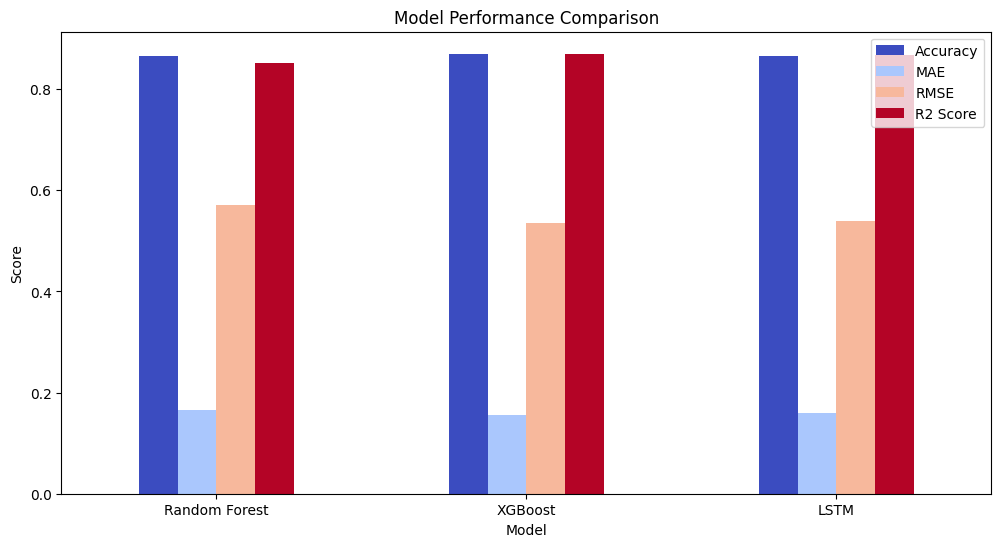

In [ ]:
# 📌 Create a bar chart for model performance
df_results.set_index("Model", inplace=True)

# 📌 Plot accuracy, MAE, RMSE, R²
df_results.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="best")
plt.show()


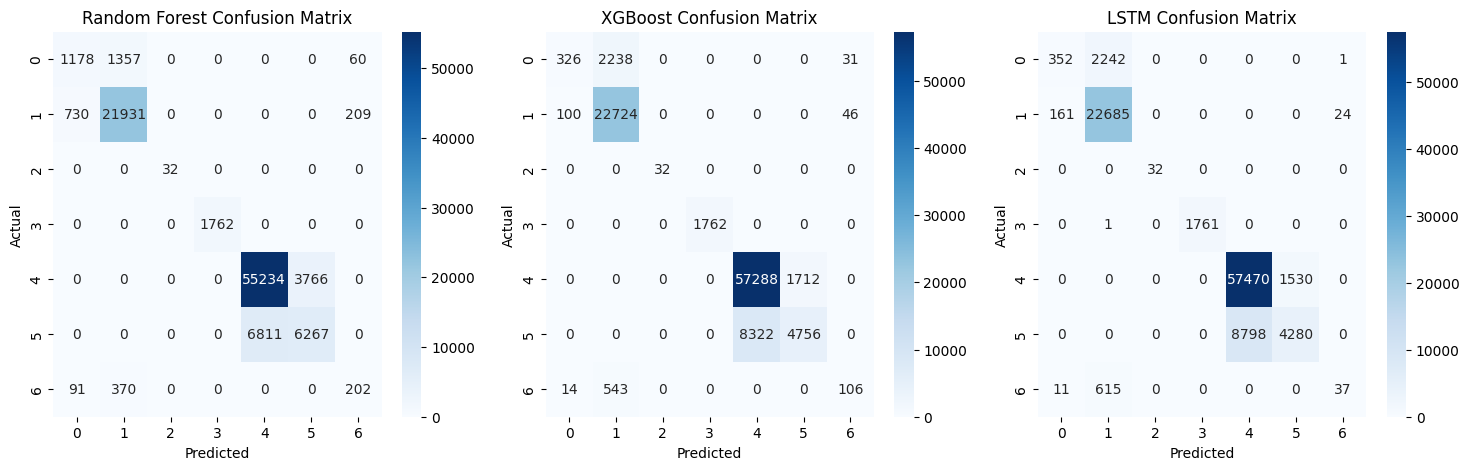

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 📌 Compute confusion matrices
rf_cm = confusion_matrix(y_test, rf_preds)
xgb_cm = confusion_matrix(y_test, xgb_preds)
lstm_cm = confusion_matrix(y_test, lstm_preds)

# 📌 Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, cm, title in zip(axes, [rf_cm, xgb_cm, lstm_cm],
                         ["Random Forest", "XGBoost", "LSTM"]):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{title} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.show()


Available keys in LSTM training history: dict_keys([])
⚠ 'loss' key not found in history!
⚠ 'accuracy' key not found in history!


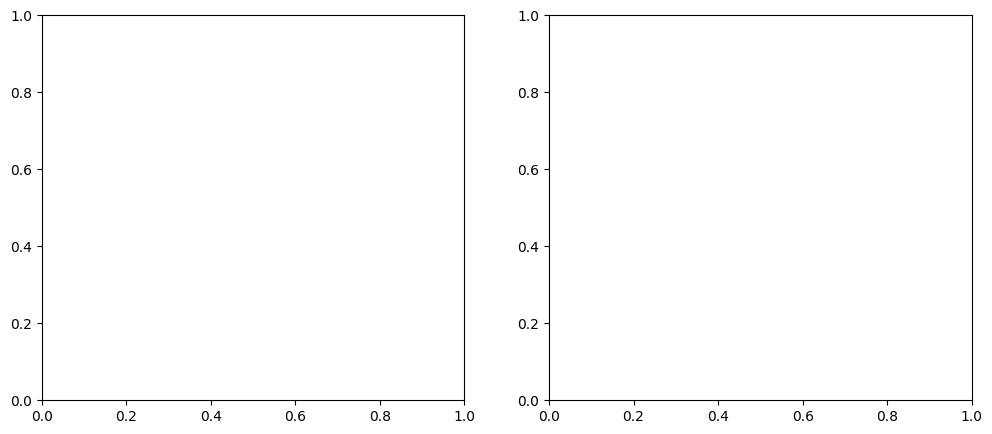

In [ ]:
# Ensure history is correctly stored from LSTM training
history = lstm_model.history.history  # Extract history object

# Check available keys in history
print("Available keys in LSTM training history:", history.keys())

# Plot training loss and accuracy
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 📌 Check if 'loss' and 'accuracy' exist in history before plotting
if "loss" in history:
    ax[0].plot(history["loss"], label="Train Loss", color="red")
    ax[0].set_title("LSTM Training Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
else:
    print("⚠ 'loss' key not found in history!")

if "accuracy" in history:
    ax[1].plot(history["accuracy"], label="Train Accuracy", color="blue")
    ax[1].set_title("LSTM Training Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
else:
    print("⚠ 'accuracy' key not found in history!")

plt.show()
